In [1]:
# =========================================================
# 0. Setup
# =========================================================

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)

import joblib

from huggingface_hub import InferenceClient

# To make results reproducible
RANDOM_STATE = 42


In [2]:
# =========================================================
# 1. Load Data
# =========================================================

# Make sure original.csv is in the same folder as this notebook
df = pd.read_csv("original.csv")

df.head()


,clientid,income,age,loan,default
0,1,66155.925095,59.017015,8106.532131,0
1,2,34415.153966,48.117153,6564.745018,0
2,3,57317.170063,63.108049,8020.953296,0
3,4,42709.534201,45.751972,6103.642260,0
4,5,66952.688845,18.584336,8770.099235,1


In [3]:
# Basic info
df.info()
print("\nMissing values:\n", df.isna().sum())

df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   clientid  2000 non-null   int64  
 1   income    2000 non-null   float64
 2   age       1997 non-null   float64
 3   loan      2000 non-null   float64
 4   default   2000 non-null   int64  
dtypes: float64(3), int64(2)
memory usage: 78.3 KB

Missing values:
 clientid    0
income      0
age         3
loan        0
default     0
dtype: int64


,clientid,income,age,loan,default
count,2000.000000,2000.000000,1997.000000,2000.000000,2000.000000
mean,1000.500000,45331.600018,40.807559,4444.369695,0.141500
std,577.494589,14326.327119,13.624469,3045.410024,0.348624
min,1.000000,20014.489470,-52.423280,1.377630,0.000000
25%,500.750000,32796.459717,28.990415,1939.708847,0.000000
50%,1000.500000,45789.117313,41.317159,3974.719419,0.000000
75%,1500.250000,57791.281668,52.587040,6432.410625,0.000000
max,2000.000000,69995.685578,63.971796,13766.051239,1.000000


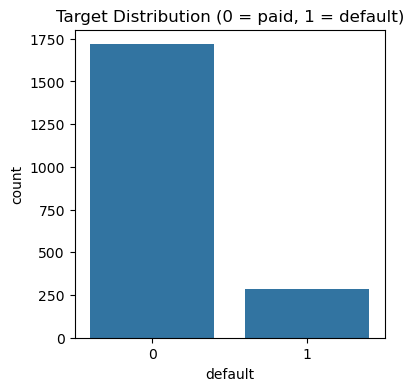

Default rate: 0.141 (14.1%)


In [4]:
# =========================================================
# 2. Exploratory Data Analysis (EDA)
# =========================================================

# Class balance
plt.figure(figsize=(4,4))
sns.countplot(x="default", data=df)
plt.title("Target Distribution (0 = paid, 1 = default)")
plt.show()

default_rate = df["default"].mean()
print(f"Default rate: {default_rate:.3f} ({default_rate*100:.1f}%)")


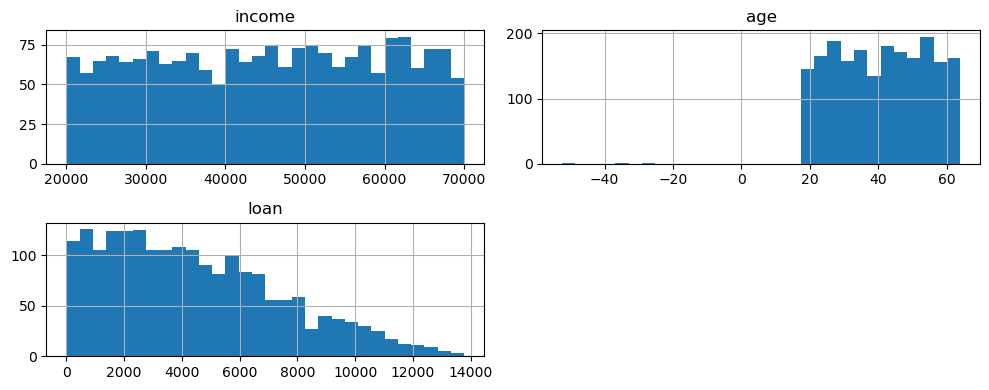

In [5]:
# Histograms of numeric features
numeric_cols = ["income", "age", "loan"]

df[numeric_cols].hist(bins=30, figsize=(10,4))
plt.tight_layout()
plt.show()


In [6]:
# =========================================================
# 3. Data Cleaning & Feature Engineering
# =========================================================

# 3.1 Handle missing values
# Age has 3 missing values -> fill with median
age_median = df["age"].median()
df["age"] = df["age"].fillna(age_median)

print("Missing values after imputation:\n", df.isna().sum())


Missing values after imputation:
 clientid    0
income      0
age         0
loan        0
default     0
dtype: int64


In [7]:
# 3.2 Feature engineering

# Debt-to-income ratio (DTI) = loan / income
df["dti"] = df["loan"] / df["income"]

# Loan-to-income ratio (can be same as DTI here, but we keep both for clarity)
df["loan_to_income"] = df["loan"] / df["income"]

df[["income", "age", "loan", "dti", "loan_to_income"]].head()


,income,age,loan,dti,loan_to_income
0,66155.925095,59.017015,8106.532131,0.122537,0.122537
1,34415.153966,48.117153,6564.745018,0.190752,0.190752
2,57317.170063,63.108049,8020.953296,0.139940,0.139940
3,42709.534201,45.751972,6103.642260,0.142911,0.142911
4,66952.688845,18.584336,8770.099235,0.130989,0.130989


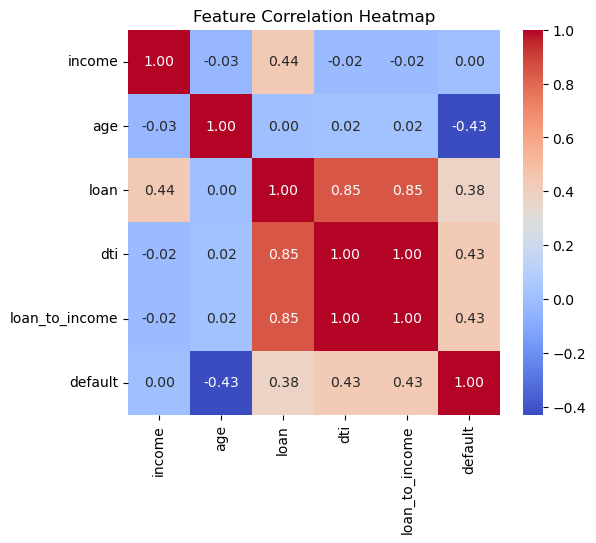

In [8]:
# Optional: correlation heatmap
plt.figure(figsize=(6,5))
sns.heatmap(
    df[["income", "age", "loan", "dti", "loan_to_income", "default"]].corr(),
    annot=True, cmap="coolwarm", fmt=".2f"
)
plt.title("Feature Correlation Heatmap")
plt.show()


In [9]:
# =========================================================
# 4. Train / Test Split
# =========================================================

FEATURES = ["income", "age", "loan", "dti", "loan_to_income"]
TARGET = "default"

X = df[FEATURES]
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

X_train.shape, X_test.shape


((1600, 5), (400, 5))

In [10]:
# =========================================================
# 5. Scaling (VERY IMPORTANT for consistency later)
# =========================================================

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


In [11]:
# =========================================================
# 6. Train Models
# =========================================================

# 6.1 Logistic Regression
lr_model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

# 6.2 Random Forest
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=RANDOM_STATE,
    class_weight="balanced"   # in case of slight imbalance
)
rf_model.fit(X_train, y_train)   # RF can work on unscaled data


RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

=== Logistic Regression ===
Accuracy: 0.9475

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       343
           1       0.85      0.77      0.81        57

    accuracy                           0.95       400
   macro avg       0.90      0.87      0.89       400
weighted avg       0.95      0.95      0.95       400



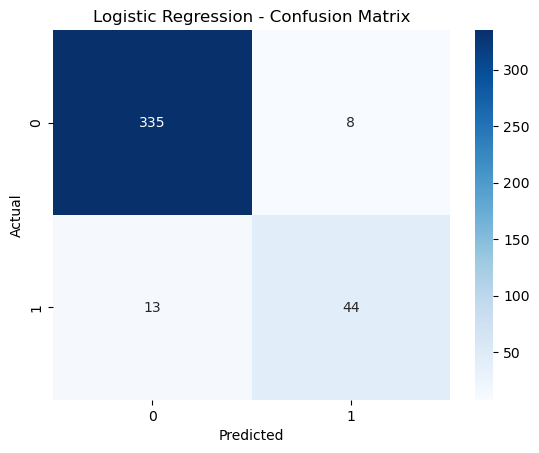

In [12]:
# =========================================================
# 7. Evaluation
# =========================================================

# 7.1 Logistic Regression
lr_pred = lr_model.predict(X_test_scaled)
lr_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

print("=== Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test, lr_pred))
print("\nClassification Report:\n", classification_report(y_test, lr_pred))

cm_lr = confusion_matrix(y_test, lr_pred)
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues")
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


=== Random Forest ===
Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       343
           1       1.00      1.00      1.00        57

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



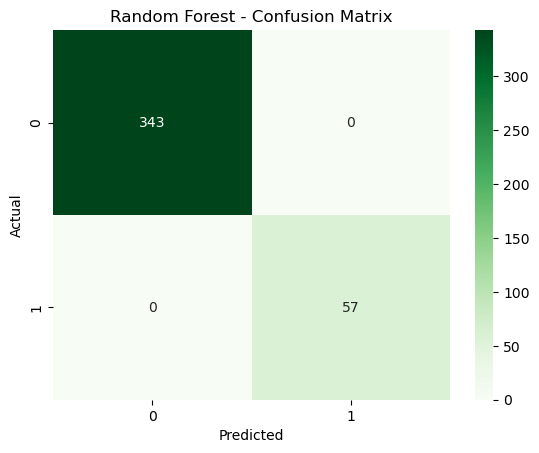

In [13]:
# 7.2 Random Forest
rf_pred = rf_model.predict(X_test)
rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]

print("=== Random Forest ===")
print("Accuracy:", accuracy_score(y_test, rf_pred))
print("\nClassification Report:\n", classification_report(y_test, rf_pred))

cm_rf = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens")
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


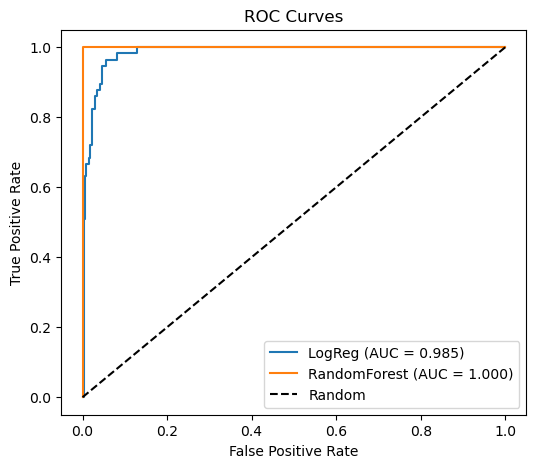

In [14]:
# 7.3 ROC Curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_pred_proba)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_pred_proba)

lr_auc = auc(lr_fpr, lr_tpr)
rf_auc = auc(rf_fpr, rf_tpr)

plt.figure(figsize=(6,5))
plt.plot(lr_fpr, lr_tpr, label=f"LogReg (AUC = {lr_auc:.3f})")
plt.plot(rf_fpr, rf_tpr, label=f"RandomForest (AUC = {rf_auc:.3f})")
plt.plot([0,1], [0,1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()


In [15]:
print(f"LogReg AUC: {lr_auc:.4f}")
print(f"RandomForest AUC: {rf_auc:.4f}")


LogReg AUC: 0.9847
RandomForest AUC: 1.0000


In [16]:
# =========================================================
# 8. Choose Best Model & Save Artifacts
# =========================================================

# Here, we'll assume RandomForest is the primary model
# (you can switch to lr_model if you prefer).

BEST_MODEL = rf_model

# Save the model and scaler
joblib.dump(BEST_MODEL, "credit_risk_model.pkl")
joblib.dump(scaler, "scaler.pkl")  # scaler was fit on FEATURES

print("Saved credit_risk_model.pkl and scaler.pkl")


Saved credit_risk_model.pkl and scaler.pkl


In [25]:
!pip install transformers accelerate sentencepiece


   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   --------- ------------------------------ 0.3/1.1 MB ? eta -:--:--
   ---------------------------------------- 1.1/1.1 MB 2.8 MB/s eta 0:00:00



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
import joblib
import numpy as np
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Load ML model & scaler
model = joblib.load("credit_risk_model.pkl")
scaler = joblib.load("scaler.pkl")

# Load local small LLM
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")
llm = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base")


def predict_default(income, age, loan):
    dti = loan / income
    lti = loan / income

    x = np.array([[income, age, loan, dti, lti]])
    x_scaled = scaler.transform(x)

    prob = model.predict_proba(x_scaled)[0][1]

    features = {
        "income": income,
        "age": age,
        "loan": loan,
        "dti": round(dti, 3),
        "loan_to_income": round(lti, 3)
    }

    return float(prob), features


def explain_risk(prob, f):

    prompt = f"""
    Explain the credit risk for this applicant.

    Features:
    - Income: {f['income']}
    - Age: {f['age']}
    - Loan Amount: {f['loan']}
    - DTI: {f['dti']}
    - Loan-to-Income: {f['loan_to_income']}

    Model predicted default probability: {prob:.3f}

    Provide:
    - Risk level (Low/Medium/High)
    - Why the risk is what it is
    - Should the bank approve the loan?
    - Recommendations to reduce risk
    """

    inputs = tokenizer(prompt, return_tensors="pt")
    outputs = llm.generate(**inputs, max_new_tokens=150)

    explanation = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return explanation


def credit_risk_agent(income, age, loan):
    prob, features = predict_default(income, age, loan)
    explanation = explain_risk(prob, features)

    return {
        "default_probability": prob,
        "explanation": explanation,
        "features": features
    }


tokenizer_config.json: 0.00B [00:00, ?B/s]

c:\Softwares\anaconda\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\rouna\.cache\huggingface\hub\models--google--flan-t5-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [27]:
result = credit_risk_agent(50000, 30, 10000)
print(result["default_probability"])
print(result["explanation"])


c:\Softwares\anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Softwares\anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0.885
Low
